# Laboratorio 2 - Pregunta 1
### Hecho por: Daniel Alonso, Álvaro García Cid, Enrique Ramos e Ignacio Regidor


##Resumen

En esta primera pregunta del laboratorio 2, se tiene un dataset acerca de una serie de ventas realizadas durante el BlackFriday a partir de las cuales se buscará mediante el empleo del algoritmo apriori encontrar reglas de asociación que nos permitan conocer diferentes patrones que se dan en estas compras y que no son apreciables a simple vista y pueden ser muy útiles para mejorar el negocio.

##Introducción al problema y pasos previos
A continuación se muestrán las librerías de Python utilizadas en esta práctica.
- Numpy: utilizada por el resto de liberías, permite la creación y el manejo de datos de forma rápida y eficiente, conteniendo estructuras de datos propias.
- Pandas: permite la creación y manejo de dataframes a partir de la base de datos empleada.
- Matplotlib.pyplot: se utilizará para graficar los distintos diagramas que permitan el estudio de los datos de forma visual.
- Mlxtend: se utiliza para llevar a cabo problemas relacionados con reglas de asociación.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mlxtend as mlx

In [ ]:
!pip install apyori

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import apyori as ap

##Preprocesamiento de los datos

Se importa la base de datos con la que se va a trabajar en este laboratorio:

In [ ]:
datos = pd.read_csv("BlackFriday.csv", encoding='latin-1')
datos.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
0,1000004,P00128942,M,46-50,7,B,2,1,1,11.0,NaN
1,1000009,P00113442,M,26-35,17,C,0,0,3,5.0,NaN
2,1000010,P00288442,F,36-45,1,B,4+,1,5,14.0,NaN
3,1000010,P00145342,F,36-45,1,B,4+,1,4,9.0,NaN
4,1000011,P00053842,F,26-35,1,C,1,0,4,5.0,12.0


Además, queremos saber el tamaño del dataset con el que se va a trabajar:

In [ ]:
datos.shape

(233599, 11)

Como vemos se trata de un dataset de 233599 filas, cada una de ellas representa una venta de un producto. En cuanto a las columnas vemos que son 11 y se tratan de distintas variables que son:
- User_ID: identificador de un usuario
- Product_ID: identificador de un producto
- Gender: género del usuario
- Age: edad del usuario
- Occupation: tipo de trabajo que realiza el usuario
- City_category: categoría de la ciudad del usuario
- Stay_In_Current_City_Years: años que lleva el usuario en la ciudad
- Marital_Status: estado civil
- Product_Category_1: categoría 1 del producto
- Product_Category_2: categoría 2 del producto
- Product_Category_3: categoría 3 del producto

Comprobamos si existen na en algunos de las columnas:

In [ ]:
for c in datos.columns:
  print("Missing Values [{0}]:".format(c), datos[c].isna().sum())

Missing Values [User_ID]: 0
Missing Values [Product_ID]: 0
Missing Values [Gender]: 0
Missing Values [Age]: 0
Missing Values [Occupation]: 0
Missing Values [City_Category]: 0
Missing Values [Stay_In_Current_City_Years]: 0
Missing Values [Marital_Status]: 0
Missing Values [Product_Category_1]: 0
Missing Values [Product_Category_2]: 72344
Missing Values [Product_Category_3]: 162562


Vemos que las únicas variables con valores NA son 'Product_Category_2' y 'Product_Category_3'. A pesar de que el número de na´s en estas dos columnas es muy grande, no podemos eliminarlas ya que son 2 de las 3 columnas que tienen datos acerca del producto vendido y se perdería demasiada información.

Por tanto, convertiremos esos na en 0 para poder trabajar con ellos.

In [ ]:
datos = datos.fillna(0)
datos.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3
0,1000004,P00128942,M,46-50,7,B,2,1,1,11.0,0.0
1,1000009,P00113442,M,26-35,17,C,0,0,3,5.0,0.0
2,1000010,P00288442,F,36-45,1,B,4+,1,5,14.0,0.0
3,1000010,P00145342,F,36-45,1,B,4+,1,4,9.0,0.0
4,1000011,P00053842,F,26-35,1,C,1,0,4,5.0,12.0


Observamos la cantidad de valores únicos que tiene cada variable, esto es necesario ya que para la realización del algoritmo apriori necesitaremos obtener los dummies de cada columna y de esta forma podremos saber el número de columnas nuevas que se generan.

In [ ]:
for c in datos.columns:
    print("Unique values [{0}]:".format(c), datos[c].unique().size)

Unique values [User_ID]: 5891
Unique values [Product_ID]: 3491
Unique values [Gender]: 2
Unique values [Age]: 7
Unique values [Occupation]: 21
Unique values [City_Category]: 3
Unique values [Stay_In_Current_City_Years]: 5
Unique values [Marital_Status]: 2
Unique values [Product_Category_1]: 18
Unique values [Product_Category_2]: 18
Unique values [Product_Category_3]: 16


Comprobamos si existen registros repetidos y los eliminamos ya que no son necesarios.

In [ ]:
datos = datos.drop_duplicates(keep='last')
datos.shape

(233599, 11)

Pasamos a categóricas las variables 'Age' y 'Stay_In_Current_City_Years'  para que no nos den problemas con el tipo de dato.

In [ ]:
datos = datos.astype({'Age': 'category', 'Stay_In_Current_City_Years': 'category'})
datos.dtypes

User_ID                          int64
Product_ID                      object
Gender                          object
Age                           category
Occupation                       int64
City_Category                   object
Stay_In_Current_City_Years    category
Marital_Status                   int64
Product_Category_1               int64
Product_Category_2             float64
Product_Category_3             float64
dtype: object

Como hemos visto antes la variable 'product_ID' contiene 3491 valores únicos por tanto la realización de los dummies y su procesamiento es muy costoso en memoria, por tanto, vamos a ver si será necesario usar estos datos teniendo en cuenta que el modelo general que realizaremos usará aquellos itemsets con un soporte mínimo de 0.5.

Creamos una tabla con los datos de 'User_ID' y 'Product_ID' y comprobamos si existen registros repetidos, es decir, que un usuario compre dos veces el mismo producto.

In [ ]:
datospr=datos[['User_ID','Product_ID']]
datospr.shape

(233599, 2)

In [ ]:
datospr = datospr.drop_duplicates(keep='last')
datospr.shape

(233599, 2)

Como vemos no hay valores repetidos, por tanto, agrupando por 'Product_ID' veremos cuantos usuarios han comprado ese producto. La frecuencia soporte en este caso será el total de usuarios entre 2 y queremos ver si alguno de estos productos lo cumple.

In [ ]:
datospr = datospr.groupby(datospr.Product_ID).count().apply(lambda x: x>2946)
datospr.head()

,User_ID
Product_ID,
P00000142,False
P00000242,False
P00000342,False
P00000442,False
P00000542,False


In [ ]:
for c in datospr.columns:
    print("Unique values [{0}]:".format(c), datospr[c].unique().size)

Unique values [User_ID]: 1


Como vemos, todos los productos tienen una frecuencia soporte inferior a la mínima por ello, ahorrando coste computacional decidimos no usar esta variable para el algoritmo apriori ya que vemos que no contiene información relevante.

Comenzamos a preparar los datos para realizar el algortimo, para ello debemos obtener los dummies de cada una de las columnas.

In [ ]:
df = pd.get_dummies(datos, columns=['Gender'])
df = pd.get_dummies(df, columns=['Age'])
df = pd.get_dummies(df, columns=['Occupation'])
df = pd.get_dummies(df, columns=['City_Category'])
df = pd.get_dummies(df, columns=['Stay_In_Current_City_Years'])
df = pd.get_dummies(df, columns=['Product_Category_1'])
df = pd.get_dummies(df, columns=['Product_Category_2'])
df = pd.get_dummies(df, columns=['Product_Category_3'])
df = pd.get_dummies(df, columns=['Marital_Status'])
df.head()

,User_ID,Product_ID,Gender_F,Gender_M,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,...,Product_Category_3_11.0,Product_Category_3_12.0,Product_Category_3_13.0,Product_Category_3_14.0,Product_Category_3_15.0,Product_Category_3_16.0,Product_Category_3_17.0,Product_Category_3_18.0,Marital_Status_0,Marital_Status_1
0,1000004,P00128942,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1000009,P00113442,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,1000010,P00288442,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1000010,P00145342,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1000011,P00053842,1,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0


Como el estudio que se va a realizar es acerca de los clientes debemos agrupar los dummies respecto al 'User_ID' y ya tendremos los datos preparados para la implementación del algoritmo.

In [ ]:
datos1 = df.groupby(df.User_ID).sum().apply(lambda x: x>0)
datos1.head()

,Gender_F,Gender_M,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,Occupation_0,...,Product_Category_3_11.0,Product_Category_3_12.0,Product_Category_3_13.0,Product_Category_3_14.0,Product_Category_3_15.0,Product_Category_3_16.0,Product_Category_3_17.0,Product_Category_3_18.0,Marital_Status_0,Marital_Status_1
User_ID,,,,,,,,,,,,,,,,,,,,,
1000001,True,False,True,False,False,False,False,False,False,False,...,False,True,False,False,False,True,False,False,True,False
1000002,False,True,False,False,False,False,False,False,True,False,...,False,False,False,True,True,True,True,False,True,False
1000003,False,True,False,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,True,True,False
1000004,False,True,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1000005,False,True,False,False,True,False,False,False,False,False,...,False,False,False,True,True,True,True,False,False,True


In [ ]:
datos1=datos1.reset_index()
datos1=datos1.drop(columns=['User_ID'])
datos1.head()

,Gender_F,Gender_M,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,Occupation_0,...,Product_Category_3_11.0,Product_Category_3_12.0,Product_Category_3_13.0,Product_Category_3_14.0,Product_Category_3_15.0,Product_Category_3_16.0,Product_Category_3_17.0,Product_Category_3_18.0,Marital_Status_0,Marital_Status_1
0,True,False,True,False,False,False,False,False,False,False,...,False,True,False,False,False,True,False,False,True,False
1,False,True,False,False,False,False,False,False,True,False,...,False,False,False,True,True,True,True,False,True,False
2,False,True,False,False,True,False,False,False,False,False,...,False,False,True,False,False,False,False,True,True,False
3,False,True,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,False,True,False,False,True,False,False,False,False,False,...,False,False,False,True,True,True,True,False,False,True


## Algoritmo apriori

Procedemos a realizar el algortimo con la base de datos general ya transformada, lo realizaremos como se ha dicho anteriormente con un soporte mínimo de 0.5:
- Soporte = Número de registros en los que aparece esa variable/Total de registros

Además debemos eliminar aquellos itemsets frecuentes que contengan 0 en la categoría de producto 2 y 3 ya que no serían reglas válidas puesto que estos se tratan de valores na y no podemos definir si esas reglas son realmente válidas o no.
Además creamos dos columnas nuevas, una con la frecuencia soporte de cada uno de los itemsets frecuentes y otra con la longitud de esos itemsets.

In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules
frequent_itemsets = apriori(datos1, min_support=0.5, use_colnames=True)
ind=(frequent_itemsets['itemsets'].apply(lambda x: 'Product_Category_2_0.0' in x) | frequent_itemsets['itemsets'].apply(lambda x: 'Product_Category_3_0.0' in x))
frq_itm=frequent_itemsets.drop(frequent_itemsets[ind].index)
frq_itm['frecuencia soporte']=frq_itm['support']*5891
frq_itm['longitud itemset']=frq_itm['itemsets'].apply(lambda x: len(x))
frq_itm

,support,itemsets,frecuencia soporte,longitud itemset
0,0.717196,(Gender_M),4225.0,1
1,0.532847,(City_Category_C),3139.0,1
2,0.910711,(Product_Category_1_1),5365.0,1
3,0.543711,(Product_Category_1_2),3203.0,1
4,0.913597,(Product_Category_1_5),5382.0,1
...,...,...,...,...
803,0.510440,"(Product_Category_1_1, Product_Category_2_2.0,...",3007.0,5
809,0.508063,"(Product_Category_1_1, Product_Category_1_8, P...",2993.0,5
863,0.501952,"(Product_Category_1_5, Product_Category_2_2.0,...",2957.0,5
868,0.508912,"(Product_Category_1_5, Product_Category_2_8.0,...",2998.0,5


Mostramos los itemsets frecuentes de longitud 1

In [ ]:
frq_itm[frq_itm['itemsets'].apply(lambda x: len(x))==1]

,support,itemsets,frecuencia soporte,longitud itemset
0,0.717196,(Gender_M),4225.0,1
1,0.532847,(City_Category_C),3139.0,1
2,0.910711,(Product_Category_1_1),5365.0,1
3,0.543711,(Product_Category_1_2),3203.0,1
4,0.913597,(Product_Category_1_5),5382.0,1
5,0.529961,(Product_Category_1_6),3122.0,1
6,0.873196,(Product_Category_1_8),5144.0,1
8,0.729588,(Product_Category_2_2.0),4298.0,1
9,0.527075,(Product_Category_2_4.0),3105.0,1
10,0.592938,(Product_Category_2_5.0),3493.0,1


Mostramos los itemsets frecuentes de longitud mayor o igual a 2

In [ ]:
for i in range(2,7):
  print('Itemsets frecuentes: tamaño',i)
  print(frq_itm[frq_itm['itemsets'].apply(lambda x: len(x))==i])

Itemsets frecuentes: tamaño 2
      support                                           itemsets  \
23   0.667119                   (Product_Category_1_1, Gender_M)   
24   0.652521                   (Gender_M, Product_Category_1_5)   
25   0.623833                   (Product_Category_1_8, Gender_M)   
27   0.551859                 (Product_Category_2_2.0, Gender_M)   
28   0.596673                 (Gender_M, Product_Category_2_8.0)   
..        ...                                                ...   
129  0.584281  (Product_Category_2_16.0, Product_Category_2_1...   
131  0.554575  (Product_Category_3_16.0, Product_Category_2_1...   
132  0.536411  (Product_Category_2_16.0, Product_Category_2_1...   
134  0.544559  (Product_Category_3_16.0, Product_Category_2_1...   
136  0.553217  (Product_Category_2_16.0, Product_Category_3_1...   

     frecuencia soporte  longitud itemset  
23               3930.0                 2  
24               3844.0                 2  
25               3675

Por último obtenemos las reglas asociadas a los itemsets frecuentes, en este caso utilizaremos como métrica la confianza y el umbral mínimo de esta confianza será 0.8.
- Confianza = soporte(itemset)/soporte(antecedente)

In [ ]:
rules = association_rules(frq_itm, metric='confidence', min_threshold=0.8)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Gender_M),(Product_Category_1_1),0.717196,0.910711,0.667119,0.930178,1.021375,0.013961,1.278796
1,(Gender_M),(Product_Category_1_5),0.717196,0.913597,0.652521,0.909822,0.995868,-0.002707,0.958143
2,(Gender_M),(Product_Category_1_8),0.717196,0.873196,0.623833,0.869822,0.996136,-0.002420,0.974082
3,(Gender_M),(Product_Category_2_8.0),0.717196,0.830929,0.596673,0.831953,1.001233,0.000734,1.006094
4,(Product_Category_1_2),(Product_Category_1_1),0.543711,0.910711,0.523850,0.963472,1.057933,0.028686,2.444375
...,...,...,...,...,...,...,...,...,...
1017,"(Product_Category_1_1, Product_Category_2_2.0,...","(Product_Category_1_8, Product_Category_1_5, P...",0.584790,0.715838,0.501952,0.858345,1.199078,0.083337,2.006023
1018,"(Product_Category_2_8.0, Product_Category_2_2....","(Product_Category_1_1, Product_Category_1_8, P...",0.537430,0.753183,0.501952,0.933986,1.240052,0.097169,3.738867
1019,"(Product_Category_2_2.0, Product_Category_1_8,...","(Product_Category_1_1, Product_Category_1_5, P...",0.549652,0.732134,0.501952,0.913218,1.247338,0.099533,3.086658
1020,"(Product_Category_2_2.0, Product_Category_1_8,...","(Product_Category_1_1, Product_Category_1_5, P...",0.583093,0.677644,0.501952,0.860844,1.270349,0.106823,2.316513


## Pregunta 1: Prueba al menos tres configuraciones de soporte y frecuencia para cada género, edad y tipo de producto.

Para la implementación de esta primera pregunta debemos seleccionar primero aquellas columnas que están relacionadas con la edad, género y tipo de producto.

In [ ]:
datos2=datos[['User_ID','Age','Gender','Product_Category_1','Product_Category_2','Product_Category_3']]
datos2.head()

,User_ID,Age,Gender,Product_Category_1,Product_Category_2,Product_Category_3
0,1000004,46-50,M,1,11.0,0.0
1,1000009,26-35,M,3,5.0,0.0
2,1000010,36-45,F,5,14.0,0.0
3,1000010,36-45,F,4,9.0,0.0
4,1000011,26-35,F,4,5.0,12.0


Al igual que en el caso general obtendremos los dummies de las diferentes variables y volvemos a agrupar por la variable 'User_ID'.

In [ ]:
df2 = pd.get_dummies(datos2, columns=['Gender'])
df2 = pd.get_dummies(df2, columns=['Age'])
df2 = pd.get_dummies(df2, columns=['Product_Category_1'])
df2 = pd.get_dummies(df2, columns=['Product_Category_2'])
df2 = pd.get_dummies(df2, columns=['Product_Category_3'])
df2.head()

,User_ID,Gender_F,Gender_M,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,...,Product_Category_3_9.0,Product_Category_3_10.0,Product_Category_3_11.0,Product_Category_3_12.0,Product_Category_3_13.0,Product_Category_3_14.0,Product_Category_3_15.0,Product_Category_3_16.0,Product_Category_3_17.0,Product_Category_3_18.0
0,1000004,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1000009,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1000010,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1000010,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1000011,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [ ]:
datos21 = df2.groupby(df2.User_ID).sum().apply(lambda x: x>0)
datos21.head()

,Gender_F,Gender_M,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,Product_Category_1_1,...,Product_Category_3_9.0,Product_Category_3_10.0,Product_Category_3_11.0,Product_Category_3_12.0,Product_Category_3_13.0,Product_Category_3_14.0,Product_Category_3_15.0,Product_Category_3_16.0,Product_Category_3_17.0,Product_Category_3_18.0
User_ID,,,,,,,,,,,,,,,,,,,,,
1000001,True,False,True,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False
1000002,False,True,False,False,False,False,False,False,True,True,...,False,False,False,False,False,True,True,True,True,False
1000003,False,True,False,False,True,False,False,False,False,True,...,True,False,False,False,True,False,False,False,False,True
1000004,False,True,False,False,False,False,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1000005,False,True,False,False,True,False,False,False,False,True,...,False,False,False,False,False,True,True,True,True,False


In [ ]:
datos21=datos21.reset_index()
datos21=datos21.drop(columns=['User_ID'])
datos21.head()

,Gender_F,Gender_M,Age_0-17,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,Product_Category_1_1,...,Product_Category_3_9.0,Product_Category_3_10.0,Product_Category_3_11.0,Product_Category_3_12.0,Product_Category_3_13.0,Product_Category_3_14.0,Product_Category_3_15.0,Product_Category_3_16.0,Product_Category_3_17.0,Product_Category_3_18.0
0,True,False,True,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False
1,False,True,False,False,False,False,False,False,True,True,...,False,False,False,False,False,True,True,True,True,False
2,False,True,False,False,True,False,False,False,False,True,...,True,False,False,False,True,False,False,False,False,True
3,False,True,False,False,False,False,True,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,False,True,False,False,True,False,False,False,False,True,...,False,False,False,False,False,True,True,True,True,False


La primera de las configuraciones que se va a emplear va a ser con un soporte mínimo de 0.5

In [ ]:
frequent_itemsets2 = apriori(datos21, min_support=0.5, use_colnames=True)
ind=(frequent_itemsets2['itemsets'].apply(lambda x: 'Product_Category_2_0.0' in x) | frequent_itemsets2['itemsets'].apply(lambda x: 'Product_Category_3_0.0' in x))
frq_itm2=frequent_itemsets2.drop(frequent_itemsets2[ind].index)
frq_itm2['longitud itemset']=frq_itm2['itemsets'].apply(lambda x: len(x))
frq_itm2

,support,itemsets,longitud itemset
0,0.717196,(Gender_M),1
1,0.910711,(Product_Category_1_1),1
2,0.543711,(Product_Category_1_2),1
3,0.913597,(Product_Category_1_5),1
4,0.529961,(Product_Category_1_6),1
...,...,...,...
787,0.510440,"(Product_Category_1_1, Product_Category_2_2.0,...",5
793,0.508063,"(Product_Category_1_1, Product_Category_2_14.0...",5
847,0.501952,"(Product_Category_1_5, Product_Category_2_2.0,...",5
852,0.508912,"(Product_Category_1_5, Product_Category_2_14.0...",5


In [ ]:
frq_itm2[frq_itm2['itemsets'].apply(lambda x: len(x))==1]

,support,itemsets,longitud itemset
0,0.717196,(Gender_M),1
1,0.910711,(Product_Category_1_1),1
2,0.543711,(Product_Category_1_2),1
3,0.913597,(Product_Category_1_5),1
4,0.529961,(Product_Category_1_6),1
5,0.873196,(Product_Category_1_8),1
7,0.729588,(Product_Category_2_2.0),1
8,0.527075,(Product_Category_2_4.0),1
9,0.592938,(Product_Category_2_5.0),1
10,0.516890,(Product_Category_2_6.0),1


In [ ]:
for i in range(2,7):
  print('Itemsets frecuentes: tamaño',i)
  print(frq_itm2[frq_itm2['itemsets'].apply(lambda x: len(x))==i])

Itemsets frecuentes: tamaño 2
      support                                           itemsets  \
21   0.667119                   (Product_Category_1_1, Gender_M)   
22   0.652521                   (Gender_M, Product_Category_1_5)   
23   0.623833                   (Product_Category_1_8, Gender_M)   
25   0.551859                 (Product_Category_2_2.0, Gender_M)   
26   0.596673                 (Gender_M, Product_Category_2_8.0)   
..        ...                                                ...   
122  0.584281  (Product_Category_2_16.0, Product_Category_2_1...   
124  0.554575  (Product_Category_3_16.0, Product_Category_2_1...   
125  0.536411  (Product_Category_2_16.0, Product_Category_2_1...   
127  0.544559  (Product_Category_3_16.0, Product_Category_2_1...   
129  0.553217  (Product_Category_2_16.0, Product_Category_3_1...   

     longitud itemset  
21                  2  
22                  2  
23                  2  
25                  2  
26                  2  
..       

In [ ]:
rules2 = association_rules(frq_itm2, metric='confidence', min_threshold=0.8)
print(rules2)

                                            antecedents  \
0                                            (Gender_M)   
1                                            (Gender_M)   
2                                            (Gender_M)   
3                                            (Gender_M)   
4                                (Product_Category_1_2)   
...                                                 ...   
1014  (Product_Category_1_1, Product_Category_2_2.0,...   
1015  (Product_Category_2_8.0, Product_Category_2_2....   
1016  (Product_Category_2_2.0, Product_Category_1_8,...   
1017  (Product_Category_2_2.0, Product_Category_1_8,...   
1018  (Product_Category_2_2.0, Product_Category_2_14.0)   

                                            consequents  antecedent support  \
0                                (Product_Category_1_1)            0.717196   
1                                (Product_Category_1_5)            0.717196   
2                                (Product_Category_1_8

En la segunda de las configuraciones el soporte mínimo pasa a ser 0.8

In [ ]:
frequent_itemsets3 = apriori(datos21, min_support=0.6, use_colnames=True)
ind=(frequent_itemsets3['itemsets'].apply(lambda x: 'Product_Category_2_0.0' in x) | frequent_itemsets3['itemsets'].apply(lambda x: 'Product_Category_3_0.0' in x))
frq_itm3=frequent_itemsets3.drop(frequent_itemsets3[ind].index)
frq_itm3['longitud itemset']=frq_itm3['itemsets'].apply(lambda x: len(x))
frq_itm3

,support,itemsets,longitud itemset
0,0.717196,(Gender_M),1
1,0.910711,(Product_Category_1_1),1
2,0.913597,(Product_Category_1_5),1
3,0.873196,(Product_Category_1_8),1
5,0.729588,(Product_Category_2_2.0),1
...,...,...,...
153,0.604651,"(Product_Category_1_1, Product_Category_1_8, P...",4
160,0.603633,"(Product_Category_1_1, Product_Category_2_2.0,...",4
162,0.619589,"(Product_Category_1_1, Product_Category_2_8.0,...",4
174,0.602954,"(Product_Category_1_1, Product_Category_1_8, P...",4


In [ ]:
frq_itm3[frq_itm3['itemsets'].apply(lambda x: len(x))==1]

,support,itemsets,longitud itemset
0,0.717196,(Gender_M),1
1,0.910711,(Product_Category_1_1),1
2,0.913597,(Product_Category_1_5),1
3,0.873196,(Product_Category_1_8),1
5,0.729588,(Product_Category_2_2.0),1
6,0.830929,(Product_Category_2_8.0),1
7,0.757936,(Product_Category_2_14.0),1
8,0.656765,(Product_Category_2_15.0),1
9,0.723986,(Product_Category_2_16.0),1
11,0.670175,(Product_Category_3_16.0),1


In [ ]:
for i in range(2,7):
  print('Itemsets frecuentes: tamaño',i)
  print(frq_itm3[frq_itm3['itemsets'].apply(lambda x: len(x))==i])

Itemsets frecuentes: tamaño 2
     support                                           itemsets  \
12  0.667119                   (Product_Category_1_1, Gender_M)   
13  0.652521                   (Gender_M, Product_Category_1_5)   
14  0.623833                   (Product_Category_1_8, Gender_M)   
17  0.835682       (Product_Category_1_1, Product_Category_1_5)   
18  0.802750       (Product_Category_1_1, Product_Category_1_8)   
20  0.729588     (Product_Category_1_1, Product_Category_2_2.0)   
21  0.776269     (Product_Category_1_1, Product_Category_2_8.0)   
22  0.704804    (Product_Category_1_1, Product_Category_2_14.0)   
23  0.639280    (Product_Category_1_1, Product_Category_2_15.0)   
24  0.691224    (Product_Category_1_1, Product_Category_2_16.0)   
26  0.648956    (Product_Category_1_1, Product_Category_3_16.0)   
27  0.814802       (Product_Category_1_8, Product_Category_1_5)   
29  0.677135     (Product_Category_2_2.0, Product_Category_1_5)   
30  0.782889     (Product_Catego

In [ ]:
rules3 = association_rules(frq_itm3, metric='confidence', min_threshold=0.8)
print(rules3)

                                           antecedents  \
0                                           (Gender_M)   
1                                           (Gender_M)   
2                                           (Gender_M)   
3                               (Product_Category_1_1)   
4                               (Product_Category_1_5)   
..                                                 ...   
187    (Product_Category_1_8, Product_Category_2_14.0)   
188    (Product_Category_1_5, Product_Category_2_14.0)   
189  (Product_Category_2_8.0, Product_Category_2_14.0)   
190     (Product_Category_1_8, Product_Category_2_8.0)   
191                          (Product_Category_2_14.0)   

                                           consequents  antecedent support  \
0                               (Product_Category_1_1)            0.717196   
1                               (Product_Category_1_5)            0.717196   
2                               (Product_Category_1_8)            0.7

En la tercera de las configuraciones el soporte mínimo pasa a ser 0.7

In [ ]:
frequent_itemsets4 = apriori(datos21, min_support=0.7, use_colnames=True)
ind=(frequent_itemsets4['itemsets'].apply(lambda x: 'Product_Category_2_0.0' in x) | frequent_itemsets4['itemsets'].apply(lambda x: 'Product_Category_3_0.0' in x))
frq_itm4=frequent_itemsets4.drop(frequent_itemsets4[ind].index)
frq_itm4['longitud itemset']=frq_itm4['itemsets'].apply(lambda x: len(x))
frq_itm4

,support,itemsets,longitud itemset
0,0.717196,(Gender_M),1
1,0.910711,(Product_Category_1_1),1
2,0.913597,(Product_Category_1_5),1
3,0.873196,(Product_Category_1_8),1
5,0.729588,(Product_Category_2_2.0),1
6,0.830929,(Product_Category_2_8.0),1
7,0.757936,(Product_Category_2_14.0),1
8,0.723986,(Product_Category_2_16.0),1
11,0.835682,"(Product_Category_1_1, Product_Category_1_5)",2
12,0.802750,"(Product_Category_1_1, Product_Category_1_8)",2


In [ ]:
frq_itm4[frq_itm4['itemsets'].apply(lambda x: len(x))==1]

,support,itemsets,longitud itemset
0,0.717196,(Gender_M),1
1,0.910711,(Product_Category_1_1),1
2,0.913597,(Product_Category_1_5),1
3,0.873196,(Product_Category_1_8),1
5,0.729588,(Product_Category_2_2.0),1
6,0.830929,(Product_Category_2_8.0),1
7,0.757936,(Product_Category_2_14.0),1
8,0.723986,(Product_Category_2_16.0),1


In [ ]:
for i in range(2,7):
  print('Itemsets frecuentes: tamaño',i)
  print(frq_itm4[frq_itm4['itemsets'].apply(lambda x: len(x))==i])

Itemsets frecuentes: tamaño 2
     support                                         itemsets  \
11  0.835682     (Product_Category_1_1, Product_Category_1_5)   
12  0.802750     (Product_Category_1_1, Product_Category_1_8)   
14  0.729588   (Product_Category_1_1, Product_Category_2_2.0)   
15  0.776269   (Product_Category_1_1, Product_Category_2_8.0)   
16  0.704804  (Product_Category_1_1, Product_Category_2_14.0)   
18  0.814802     (Product_Category_1_8, Product_Category_1_5)   
20  0.782889   (Product_Category_1_5, Product_Category_2_8.0)   
21  0.727381  (Product_Category_1_5, Product_Category_2_14.0)   
24  0.748939   (Product_Category_1_8, Product_Category_2_8.0)   
25  0.703276  (Product_Category_1_8, Product_Category_2_14.0)   

    longitud itemset  
11                 2  
12                 2  
14                 2  
15                 2  
16                 2  
18                 2  
20                 2  
21                 2  
24                 2  
25                 2  
I

In [ ]:
rules41 = association_rules(frq_itm4, metric='confidence', min_threshold=0.8)
print(rules41)

                                       antecedents  \
0                           (Product_Category_1_1)   
1                           (Product_Category_1_5)   
2                           (Product_Category_1_1)   
3                           (Product_Category_1_8)   
4                           (Product_Category_1_1)   
5                         (Product_Category_2_2.0)   
6                           (Product_Category_1_1)   
7                         (Product_Category_2_8.0)   
8                        (Product_Category_2_14.0)   
9                           (Product_Category_1_8)   
10                          (Product_Category_1_5)   
11                          (Product_Category_1_5)   
12                        (Product_Category_2_8.0)   
13                       (Product_Category_2_14.0)   
14                          (Product_Category_1_8)   
15                        (Product_Category_2_8.0)   
16                          (Product_Category_1_8)   
17                       (Pr

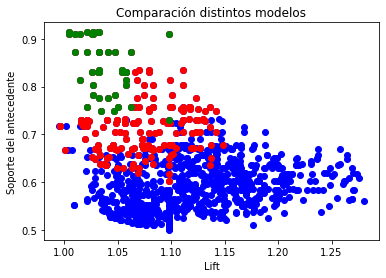

In [ ]:
plt.scatter(rules2['lift'],rules2['antecedent support'],color='blue')
plt.scatter(rules3['lift'],rules3['antecedent support'],color='red')
plt.scatter(rules41['lift'],rules41['antecedent support'],color='green')
plt.rcParams.update({'figure.figsize':(10,8), 'figure.dpi':100})

plt.title('Comparación distintos modelos')
plt.xlabel('Lift')
plt.ylabel('Soporte del antecedente')
plt.show()

Como se puede ver en todas ellas además la configuración a la hora de la obtención de las reglas se emplea una métrica basada en la confianza y con un umbral mínimo de 0.8.

Observando las 3 configuraciones diferentes implementadas vemos como el número de itemsets frecuentes disminuye considerablemente a medida que se aumenta el soporte mínimo, esto quiere decir, que el aumente de este valor mínimo supone obtener un número de reglas menor.
Además observando el gráfico de dispersión en el cual se compara el soporte del antecedente con el lift que es una métrica empleada a la hora de la realización de las reglas (lift>1 la regla es buena), podemos ver como los puntos azules que son aquellas reglas asociadas al modelo con un soporte mínimo de 0.5 además de ser más como deciamos antes son aquellas reglas mejores, ya que su lift es el más alto, en cambio las reglas verdes que son las del modelo con soporte mínimo vemos como tienden a ser aquellas con el lift más bajo.
Esto lo que quiere decir es que aquellas reglas cuyo antecedente aparece casi siempre en los registros, no son muy fiables, en cambio hay reglas cuyo antecedente está menos presente, es decir, courre menos veces en las compras, son reglas más fiables.

## Pregunta 2: ¿Qué diferencias hay entre usar soporte y frecuencia? 

Para conocer la diferencia vamos a utilizar el dataset general y vamos a crear dos configuraciones de algoritmo apriori y en cada una de ellas vamos a añadir una columna que indique la frecuencia soporte.

In [ ]:
frequent_itemsets = apriori(datos1, min_support=0.5, use_colnames=True)
ind=(frequent_itemsets['itemsets'].apply(lambda x: 'Product_Category_2_0.0' in x) | frequent_itemsets['itemsets'].apply(lambda x: 'Product_Category_3_0.0' in x))
frq_itm=frequent_itemsets.drop(frequent_itemsets[ind].index)
frq_itm['frecuencia soporte']=frq_itm['support']*5891
frq_itm

,support,itemsets,frecuencia soporte
0,0.717196,(Gender_M),4225.0
1,0.532847,(City_Category_C),3139.0
2,0.910711,(Product_Category_1_1),5365.0
3,0.543711,(Product_Category_1_2),3203.0
4,0.913597,(Product_Category_1_5),5382.0
...,...,...,...
803,0.510440,"(Product_Category_1_1, Product_Category_2_2.0,...",3007.0
809,0.508063,"(Product_Category_1_1, Product_Category_1_8, P...",2993.0
863,0.501952,"(Product_Category_1_5, Product_Category_2_2.0,...",2957.0
868,0.508912,"(Product_Category_1_5, Product_Category_2_8.0,...",2998.0


In [ ]:
frequent_itemsets = apriori(datos1, min_support=0.7, use_colnames=True)
ind=(frequent_itemsets['itemsets'].apply(lambda x: 'Product_Category_2_0.0' in x) | frequent_itemsets['itemsets'].apply(lambda x: 'Product_Category_3_0.0' in x))
frq_itm11=frequent_itemsets.drop(frequent_itemsets[ind].index)
frq_itm11['frecuencia soporte']=frq_itm11['support']*5891
frq_itm11

,support,itemsets,frecuencia soporte
0,0.717196,(Gender_M),4225.0
1,0.910711,(Product_Category_1_1),5365.0
2,0.913597,(Product_Category_1_5),5382.0
3,0.873196,(Product_Category_1_8),5144.0
5,0.729588,(Product_Category_2_2.0),4298.0
6,0.830929,(Product_Category_2_8.0),4895.0
7,0.757936,(Product_Category_2_14.0),4465.0
8,0.723986,(Product_Category_2_16.0),4265.0
11,0.835682,"(Product_Category_1_1, Product_Category_1_5)",4923.0
12,0.802750,"(Product_Category_1_1, Product_Category_1_8)",4729.0


Observando estas dos configuraciones podemos darnos cuenta de que el empleo de soporte y frecuencia soporte no supone diferencias en el algoritmo siempre que estos esten relacionados. 

Lo que se quiere decir con esto es que el soporte y la frecuencia soporte están relacionados ya que la frecuencia soporte es el soporte x el número de registros, por tanto, siempre que el soporte sea equivalente a la frecuencia el número de itemsets frecuentes será el mismo.
Por supuesto si no se emplea un soporte y una frecuencia soporte relacionados, se verán diferencias en la obtención de itemsets.
La principal diferencia por tanto es que el soporte es un valor entre 0 y 1 y la frecuencia soporte es un valor entre 0 y el número de transacciones.

## Pregunta 3: ¿Qué tipo reglas desaparecen según la configuración y categorías (género, edad y tipo de producto) consideradas? ¿Por qué? 

Vamos a ver la cantidad de reglas creadas que contienen la categoría ser hombre y productos de categoría 1 con el fin de ver en cada uno de los 3 modelos anteriores creados que ocurre con las reglas

In [ ]:
a=rules2[rules2['antecedents'].apply(lambda x: 'Gender_M' in x) | rules2['consequents'].apply(lambda x: 'Gender_M' in x)]
b=rules3[rules3['antecedents'].apply(lambda x: 'Gender_M' in x) | rules3['consequents'].apply(lambda x: 'Gender_M' in x)]
c=rules41[rules41['antecedents'].apply(lambda x: 'Gender_M' in x) | rules41['consequents'].apply(lambda x: 'Gender_M' in x)]

In [ ]:
print(a.shape)
print(b.shape)
print(c.shape)

(50, 9)
(6, 9)
(0, 9)


In [ ]:
a2=rules2[rules2['antecedents'].apply(lambda x: "Product_Category_1_1" in x) | rules2['consequents'].apply(lambda x: "Product_Category_1_2" in x) | rules2['consequents'].apply(lambda x: "Product_Category_1_5" in x)| rules2['consequents'].apply(lambda x: "Product_Category_1_6" in x)| rules2['consequents'].apply(lambda x: "Product_Category_1_8" in x)]
b2=rules3[rules2['antecedents'].apply(lambda x: "Product_Category_1_1" in x) | rules3['consequents'].apply(lambda x: "Product_Category_1_2" in x) | rules3['consequents'].apply(lambda x: "Product_Category_1_5" in x)| rules3['consequents'].apply(lambda x: "Product_Category_1_6" in x)| rules3['consequents'].apply(lambda x: "Product_Category_1_8" in x)]
c2=rules41[rules2['antecedents'].apply(lambda x: "Product_Category_1_1" in x) | rules41['consequents'].apply(lambda x: "Product_Category_1_2" in x) | rules41['consequents'].apply(lambda x: "Product_Category_1_5" in x)| rules41['consequents'].apply(lambda x: "Product_Category_1_6" in x)| rules41['consequents'].apply(lambda x: "Product_Category_1_8" in x)]

<ipython-input-48-8eacc08f4b16>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  b2=rules3[rules2['antecedents'].apply(lambda x: "Product_Category_1_1" in x) | rules3['consequents'].apply(lambda x: "Product_Category_1_2" in x) | rules3['consequents'].apply(lambda x: "Product_Category_1_5" in x)| rules3['consequents'].apply(lambda x: "Product_Category_1_6" in x)| rules3['consequents'].apply(lambda x: "Product_Category_1_8" in x)]
<ipython-input-48-8eacc08f4b16>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  c2=rules41[rules2['antecedents'].apply(lambda x: "Product_Category_1_1" in x) | rules41['consequents'].apply(lambda x: "Product_Category_1_2" in x) | rules41['consequents'].apply(lambda x: "Product_Category_1_5" in x)| rules41['consequents'].apply(lambda x: "Product_Category_1_6" in x)| rules41['consequents'].apply(lambda x: "Product_Category_1_8" in x)]


In [ ]:
print(a2.shape)
print(b2.shape)
print(c2.shape)

(660, 9)
(129, 9)
(24, 9)


Creamos histogramas basados en el lift de las reglas para ver si este es un valor influyente en la desaparición de reglas en cada uno de los modelos implementados.

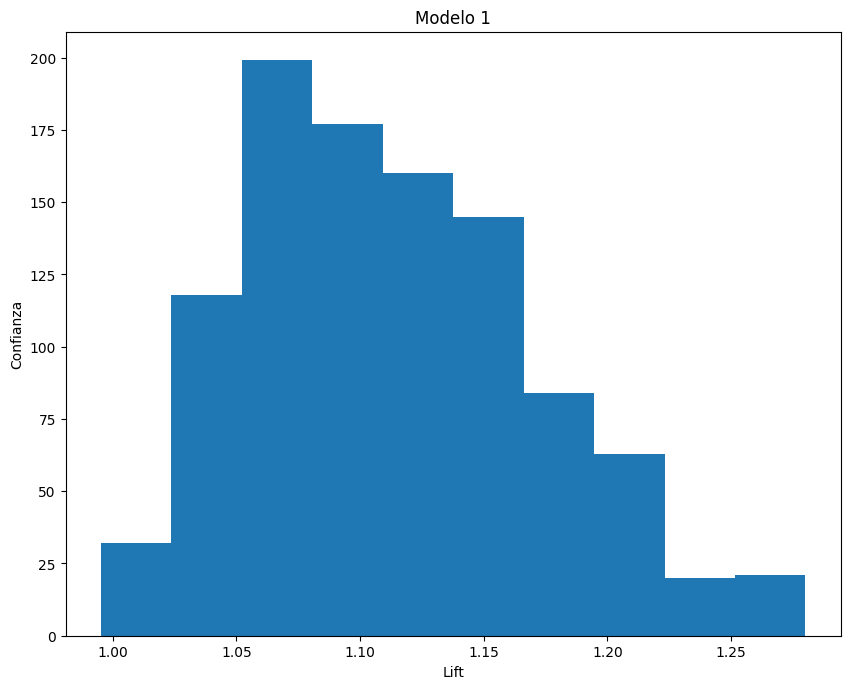

In [ ]:
(counts,bins,patches)=plt.hist(rules2['lift'])
plt.title('Modelo 1')
plt.xlabel('Lift')
plt.ylabel('Confianza')
plt.show()

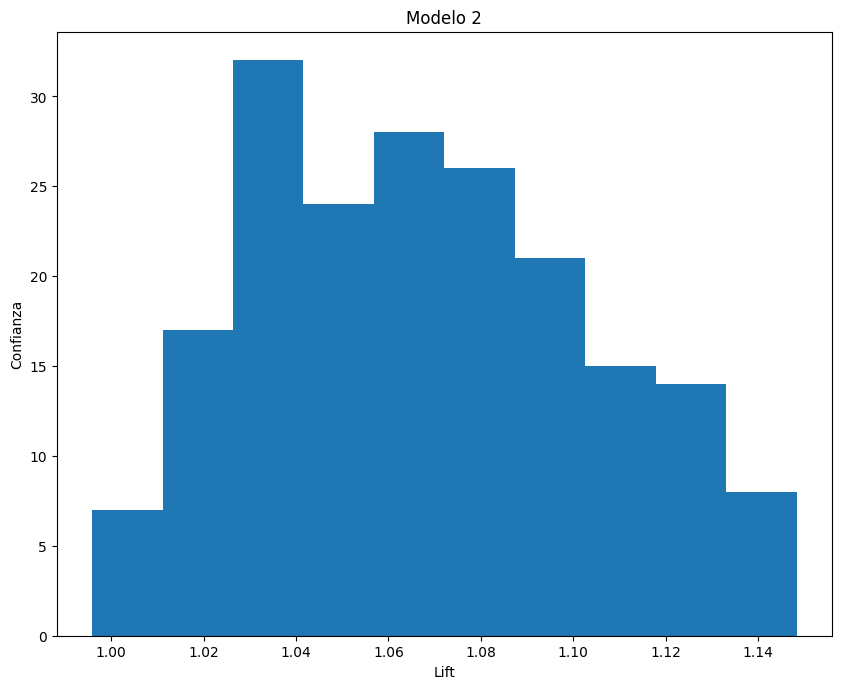

In [ ]:
(counts,bins,patches)=plt.hist(rules3['lift'])
plt.title('Modelo 2')
plt.xlabel('Lift')
plt.ylabel('Confianza')
plt.show()

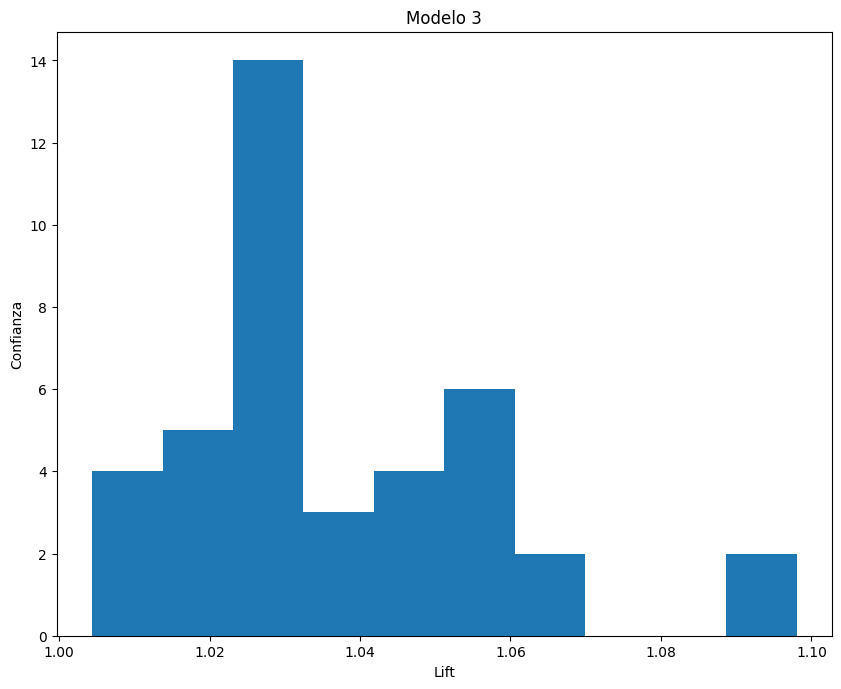

In [ ]:
(counts,bins,patches)=plt.hist(rules41['lift'])
plt.title('Modelo 3')
plt.xlabel('Lift')
plt.ylabel('Confianza')
plt.show()

Observando las reglas obtenidas anteriormente y el estudio realizado ahora, vemos como a medida que aumente el soporte mínimo el número de reglas disminuye, ya que hay menos itemsets frecuentes.
En cuanto a las categorías, vemos como en ninguna de las 3 configuraciones implementadas se obtienen reglas que contengan la edad del cliente.
La mayoría de las reglas contienen datos acerca de las categoría de los distintos productos y en algunas de ellas se incluye la categoría ser hombre como parte de la regla.
Estudiando la variable ser hombre vemos como con un soporte mínimo de 0.6 el número de reglas que contienen este itemset son 6, mientras que si aumentamos el soporte mínimio a 0.7 estas reglas desaparecen.
En cuanto a la categoría 1 del producto vemos como la mayoría de las reglas contienen información acerca de esta variable, pero al igual que ocurría con ser hombre, a medida que aumenta el soporte mínimo, se reduce el número de reglas que incluyen estos items.

Además viendo los distintos histogramas de los 3 modelos basados en el lift de las distintas reglas obtenidas, vemos como a medida que aumenta el soporte mínimo ya que los modelos están colocados en orden ascendente de soporte mínimo, vemos como se van eliminando aquellas reglas que tienen un mayor lift y además la cantidad de reglas con menor lift, van disminuyendo a medida que aumenta el soporte mínimo.

## Pregunta 4:  Para una de las configuraciones, interpreta algunas de las reglas que te hayan resultado interesantes obtenidas usando la clase association_rules y un par de configuraciones cambiando la variable metric y min_threshold.

Para realizar esta pregunta, emplearemos el tercero de los modelos creados anteriormente, es decir, aquel en el cual el soporte mínimo era 0.7 ya que se trata de aquel que tenía menos itemsets frecuentes y puede ser más fácil darse cuenta de como afecta el uso de distintas métricas a la hora de obtener las reglas. En ese modelo, se empleaba la confianza como métrica y un umbral mínimo de 0.8.
A continucaión, se crean las reglas de ese mismo modelo pero en este caso, con la métrica confianza y un umbral mínimo de 0.6

In [ ]:
rules3

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Gender_M),(Product_Category_1_1),0.717196,0.910711,0.667119,0.930178,1.021375,0.013961,1.278796
1,(Gender_M),(Product_Category_1_5),0.717196,0.913597,0.652521,0.909822,0.995868,-0.002707,0.958143
2,(Gender_M),(Product_Category_1_8),0.717196,0.873196,0.623833,0.869822,0.996136,-0.002420,0.974082
3,(Product_Category_1_1),(Product_Category_1_5),0.910711,0.913597,0.835682,0.917614,1.004397,0.003658,1.048760
4,(Product_Category_1_5),(Product_Category_1_1),0.913597,0.910711,0.835682,0.914716,1.004397,0.003658,1.046954
...,...,...,...,...,...,...,...,...,...
187,"(Product_Category_1_8, Product_Category_2_14.0)","(Product_Category_1_5, Product_Category_2_8.0)",0.703276,0.782889,0.616534,0.876659,1.119775,0.065946,1.760255
188,"(Product_Category_1_5, Product_Category_2_14.0)","(Product_Category_1_8, Product_Category_2_8.0)",0.727381,0.748939,0.616534,0.847608,1.131745,0.071770,1.647467
189,"(Product_Category_2_8.0, Product_Category_2_14.0)","(Product_Category_1_8, Product_Category_1_5)",0.671533,0.814802,0.616534,0.918099,1.126775,0.069367,2.261242
190,"(Product_Category_1_8, Product_Category_2_8.0)","(Product_Category_1_5, Product_Category_2_14.0)",0.748939,0.727381,0.616534,0.823209,1.131745,0.071770,1.542046


In [ ]:
rules32 = association_rules(frq_itm3, metric='confidence', min_threshold=0.6)
rules32

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Product_Category_1_1),(Gender_M),0.910711,0.717196,0.667119,0.732526,1.021375,0.013961,1.057314
1,(Gender_M),(Product_Category_1_1),0.717196,0.910711,0.667119,0.930178,1.021375,0.013961,1.278796
2,(Gender_M),(Product_Category_1_5),0.717196,0.913597,0.652521,0.909822,0.995868,-0.002707,0.958143
3,(Product_Category_1_5),(Gender_M),0.913597,0.717196,0.652521,0.714233,0.995868,-0.002707,0.989631
4,(Product_Category_1_8),(Gender_M),0.873196,0.717196,0.623833,0.714425,0.996136,-0.002420,0.990296
...,...,...,...,...,...,...,...,...,...
299,"(Product_Category_1_5, Product_Category_2_8.0)","(Product_Category_1_8, Product_Category_2_14.0)",0.782889,0.703276,0.616534,0.787511,1.119775,0.065946,1.396419
300,(Product_Category_2_14.0),"(Product_Category_1_8, Product_Category_1_5, P...",0.757936,0.715838,0.616534,0.813438,1.136344,0.073975,1.523151
301,(Product_Category_1_8),"(Product_Category_2_8.0, Product_Category_1_5,...",0.873196,0.653200,0.616534,0.706065,1.080933,0.046162,1.179855
302,(Product_Category_1_5),"(Product_Category_2_8.0, Product_Category_1_8,...",0.913597,0.630793,0.616534,0.674842,1.069832,0.040243,1.135471


La tercera configuración del modelo para obtener las reglas se basa en una métrica de lift y un umbral mínimo de 1.05, ya que las normas se consideran buenas con métrica lift cuando este es mayor que 1.

In [ ]:
rules33 = association_rules(frq_itm3, metric='lift', min_threshold=1.1)
rules33

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(Product_Category_1_1, Product_Category_1_5)",(Product_Category_2_2.0),0.835682,0.729588,0.677135,0.810278,1.110598,0.067432,1.425311
1,(Product_Category_2_2.0),"(Product_Category_1_1, Product_Category_1_5)",0.729588,0.835682,0.677135,0.928106,1.110598,0.067432,2.285569
2,"(Product_Category_1_1, Product_Category_1_8)",(Product_Category_2_2.0),0.802750,0.729588,0.650484,0.810319,1.110654,0.064807,1.425619
3,(Product_Category_2_2.0),"(Product_Category_1_1, Product_Category_1_8)",0.729588,0.802750,0.650484,0.891577,1.110654,0.064807,1.819272
4,"(Product_Category_1_1, Product_Category_2_8.0)",(Product_Category_2_2.0),0.776269,0.729588,0.635885,0.819156,1.122766,0.069529,1.495280
5,(Product_Category_2_2.0),"(Product_Category_1_1, Product_Category_2_8.0)",0.729588,0.776269,0.635885,0.871568,1.122766,0.069529,1.742022
6,"(Product_Category_1_5, Product_Category_2_8.0)",(Product_Category_2_14.0),0.782889,0.757936,0.653200,0.834345,1.100812,0.059820,1.461256
7,(Product_Category_2_14.0),"(Product_Category_1_5, Product_Category_2_8.0)",0.757936,0.782889,0.653200,0.861814,1.100812,0.059820,1.571151
8,"(Product_Category_1_8, Product_Category_2_8.0)",(Product_Category_2_14.0),0.748939,0.757936,0.630793,0.842248,1.111240,0.063145,1.534464
9,(Product_Category_2_14.0),"(Product_Category_1_8, Product_Category_2_8.0)",0.757936,0.748939,0.630793,0.832251,1.111240,0.063145,1.496645


Inicialmente y basandonos en el número de reglas obtenidas, vemos como existe una clara diferencia entre el empleo de las distintas métricas, las dos configuraciones en las cuales se emplea la confianza, se obtienen muchas reglas, además la disminución del valor mínimo de confianza hace que el número de reglas aumente ya que la confianza es propocional al soporte. Pero, el uso del lift hace que se obtenga reglas más exclusivas, se obtienen menos reglas, pero estas reglas son más fiables.

In [ ]:
rules3[rules3['antecedents'].apply(lambda x: 'Gender_M' in x)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Gender_M),(Product_Category_1_1),0.717196,0.910711,0.667119,0.930178,1.021375,0.013961,1.278796
1,(Gender_M),(Product_Category_1_5),0.717196,0.913597,0.652521,0.909822,0.995868,-0.002707,0.958143
2,(Gender_M),(Product_Category_1_8),0.717196,0.873196,0.623833,0.869822,0.996136,-0.002420,0.974082
36,"(Product_Category_1_1, Gender_M)",(Product_Category_1_5),0.667119,0.913597,0.609574,0.913740,1.000157,0.000096,1.001663
37,"(Gender_M, Product_Category_1_5)",(Product_Category_1_1),0.652521,0.910711,0.609574,0.934183,1.025773,0.015316,1.356624
38,(Gender_M),"(Product_Category_1_1, Product_Category_1_5)",0.717196,0.835682,0.609574,0.849941,1.017063,0.010227,1.095024


In [ ]:
rules32[rules32['antecedents'].apply(lambda x: 'Gender_M' in x)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1,(Gender_M),(Product_Category_1_1),0.717196,0.910711,0.667119,0.930178,1.021375,0.013961,1.278796
2,(Gender_M),(Product_Category_1_5),0.717196,0.913597,0.652521,0.909822,0.995868,-0.002707,0.958143
5,(Gender_M),(Product_Category_1_8),0.717196,0.873196,0.623833,0.869822,0.996136,-0.002420,0.974082
54,"(Product_Category_1_1, Gender_M)",(Product_Category_1_5),0.667119,0.913597,0.609574,0.913740,1.000157,0.000096,1.001663
56,"(Gender_M, Product_Category_1_5)",(Product_Category_1_1),0.652521,0.910711,0.609574,0.934183,1.025773,0.015316,1.356624
58,(Gender_M),"(Product_Category_1_1, Product_Category_1_5)",0.717196,0.835682,0.609574,0.849941,1.017063,0.010227,1.095024


In [ ]:
rules33[rules33['antecedents'].apply(lambda x: 'Gender_M' in x)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


Fijandonos en las reglas cuyo antecedente contiene ser hombre vemos comoafecta el uso de distintas métricas, vemos como usando la confianza el número de reglas que incluyen ser hombre en el antecedente son 6, estas reglas tienen una confianza bastante alta por lo que apriori podrían entenderse como reglas bastante fiables, además vemos que en todas ellas el ser hombre está asociado con la categoría 1 de los distintos productos.

En cambio cuando comprobamos esto en el modelo configurado con métrica lift, el cual hemos dicho que era el más selectivo ya que recogía las reglas más fiables, vemos como las reglas que contienen en el antecedente ser hombre desaparecen, por tanto, podemos concluir que ser hombre no está del todo relacionado con comprar productos cuya categoría uno sea un itemset frecuente en este modelo.

## Pregunta 5:  Dadas las mejores configuraciones. ¿Existen reglas o patrones que se repitan? ¿Podemos generalizar de alguna manera como se comportan los clientes? 

Según todo lo visto anteriormente, podemos decir que el mejor modelo de los realizados es aquel que utiliza un soporte mínimo de 0.6 ya que las reglas que se generan en este modelo son más específicas que las reglas obtenidas en el modelo con 0.5 de soporte mínimo y además con los histogramas generados se ha visto que a pesar de perder las reglas con mayor lift, se mantienen en gran proporción aquellas reglas que pueden considerarse buenas (lift(1,05-1,15)). De esta forma se es más selectivo a la hora de seleccionar los items frecuentes y se siguen obteniendo reglas bastante buenas.

En cuanto a la configuración a la hora de obtener las reglas, vemos como la métrica más selectiva y aquella que nos garantiza obtener las mejores reglas es el lift y el valor mínimo que se debe marcar es 1.1 ya que a partir de 1 las reglas se empiezan a considerar buenas

Por tanto, vamos a realizar el modelo con estas configuraciones y comprobaremos que reglas se obtienen:

In [ ]:
frequent_itemsets5 = apriori(datos21, min_support=0.6, use_colnames=True)
ind=(frequent_itemsets5['itemsets'].apply(lambda x: 'Product_Category_2_0.0' in x) | frequent_itemsets5['itemsets'].apply(lambda x: 'Product_Category_3_0.0' in x))
frq_itm5=frequent_itemsets5.drop(frequent_itemsets3[ind].index)
frq_itm5['longitud itemset']=frq_itm5['itemsets'].apply(lambda x: len(x))
frq_itm5

,support,itemsets,longitud itemset
0,0.717196,(Gender_M),1
1,0.910711,(Product_Category_1_1),1
2,0.913597,(Product_Category_1_5),1
3,0.873196,(Product_Category_1_8),1
5,0.729588,(Product_Category_2_2.0),1
...,...,...,...
153,0.604651,"(Product_Category_1_1, Product_Category_1_8, P...",4
160,0.603633,"(Product_Category_1_1, Product_Category_2_2.0,...",4
162,0.619589,"(Product_Category_1_1, Product_Category_2_8.0,...",4
174,0.602954,"(Product_Category_1_1, Product_Category_1_8, P...",4


In [ ]:
rules5 = association_rules(frq_itm5, metric='lift', min_threshold=1.1)
rules5

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(Product_Category_1_1, Product_Category_1_5)",(Product_Category_2_2.0),0.835682,0.729588,0.677135,0.810278,1.110598,0.067432,1.425311
1,(Product_Category_2_2.0),"(Product_Category_1_1, Product_Category_1_5)",0.729588,0.835682,0.677135,0.928106,1.110598,0.067432,2.285569
2,"(Product_Category_1_1, Product_Category_1_8)",(Product_Category_2_2.0),0.802750,0.729588,0.650484,0.810319,1.110654,0.064807,1.425619
3,(Product_Category_2_2.0),"(Product_Category_1_1, Product_Category_1_8)",0.729588,0.802750,0.650484,0.891577,1.110654,0.064807,1.819272
4,"(Product_Category_1_1, Product_Category_2_8.0)",(Product_Category_2_2.0),0.776269,0.729588,0.635885,0.819156,1.122766,0.069529,1.495280
5,(Product_Category_2_2.0),"(Product_Category_1_1, Product_Category_2_8.0)",0.729588,0.776269,0.635885,0.871568,1.122766,0.069529,1.742022
6,"(Product_Category_1_5, Product_Category_2_8.0)",(Product_Category_2_14.0),0.782889,0.757936,0.653200,0.834345,1.100812,0.059820,1.461256
7,(Product_Category_2_14.0),"(Product_Category_1_5, Product_Category_2_8.0)",0.757936,0.782889,0.653200,0.861814,1.100812,0.059820,1.571151
8,"(Product_Category_1_8, Product_Category_2_8.0)",(Product_Category_2_14.0),0.748939,0.757936,0.630793,0.842248,1.111240,0.063145,1.534464
9,(Product_Category_2_14.0),"(Product_Category_1_8, Product_Category_2_8.0)",0.757936,0.748939,0.630793,0.832251,1.111240,0.063145,1.496645


In [ ]:
rules5[rules5['antecedents'].apply(lambda x: 'Product_Category_1_1' in x) & rules5['consequents'].apply(lambda x: 'Product_Category_2_2.0' in x)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(Product_Category_1_1, Product_Category_1_5)",(Product_Category_2_2.0),0.835682,0.729588,0.677135,0.810278,1.110598,0.067432,1.425311
2,"(Product_Category_1_1, Product_Category_1_8)",(Product_Category_2_2.0),0.802750,0.729588,0.650484,0.810319,1.110654,0.064807,1.425619
4,"(Product_Category_1_1, Product_Category_2_8.0)",(Product_Category_2_2.0),0.776269,0.729588,0.635885,0.819156,1.122766,0.069529,1.495280
10,"(Product_Category_1_1, Product_Category_1_8, P...",(Product_Category_2_2.0),0.753183,0.729588,0.618061,0.820600,1.124744,0.068549,1.507312
11,"(Product_Category_1_1, Product_Category_1_8)","(Product_Category_2_2.0, Product_Category_1_5)",0.802750,0.677135,0.618061,0.769930,1.137042,0.074492,1.403337
12,"(Product_Category_1_1, Product_Category_1_5)","(Product_Category_1_8, Product_Category_2_2.0)",0.835682,0.650484,0.618061,0.739590,1.136984,0.074464,1.342175
24,"(Product_Category_1_1, Product_Category_1_5, P...",(Product_Category_2_2.0),0.732134,0.729588,0.603633,0.824484,1.130069,0.069477,1.540673
25,"(Product_Category_1_1, Product_Category_1_5)","(Product_Category_2_2.0, Product_Category_2_8.0)",0.835682,0.635885,0.603633,0.722324,1.135934,0.072235,1.311293
26,"(Product_Category_1_1, Product_Category_2_8.0)","(Product_Category_2_2.0, Product_Category_1_5)",0.776269,0.677135,0.603633,0.777608,1.148380,0.077994,1.451783


In [ ]:
rules5[rules5['antecedents'].apply(lambda x: 'Product_Category_1_5' in x) & rules5['consequents'].apply(lambda x: 'Product_Category_2_2.0' in x)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,"(Product_Category_1_1, Product_Category_1_5)",(Product_Category_2_2.0),0.835682,0.729588,0.677135,0.810278,1.110598,0.067432,1.425311
10,"(Product_Category_1_1, Product_Category_1_8, P...",(Product_Category_2_2.0),0.753183,0.729588,0.618061,0.820600,1.124744,0.068549,1.507312
12,"(Product_Category_1_1, Product_Category_1_5)","(Product_Category_1_8, Product_Category_2_2.0)",0.835682,0.650484,0.618061,0.739590,1.136984,0.074464,1.342175
24,"(Product_Category_1_1, Product_Category_1_5, P...",(Product_Category_2_2.0),0.732134,0.729588,0.603633,0.824484,1.130069,0.069477,1.540673
25,"(Product_Category_1_1, Product_Category_1_5)","(Product_Category_2_2.0, Product_Category_2_8.0)",0.835682,0.635885,0.603633,0.722324,1.135934,0.072235,1.311293


Vemos como en 9 de las reglas que se han obtenido con esta configuración, cuando un cliente compra un producto cuya categoría1 es 1, también compra productos cuya categoría2 es 2.

En cambio, cuando vemos si sucede lo mismo cuando el cliente compra un producto cuya categoría1 es 5, vemos como el número de reglas disminuye, aunque también podría ser una regla de asociación a tener en cuenta.

A pesar de esto lo más importante, que se saca de la segunda comprobación es que en todas las reglas que aparecen, los clientes que compran productos cuya categoría1 es 1 y también compran productos con categoría1 como 5, tienden a comprar productos cuya categoría2 es 2.0, esta regla como vemos es mejor que la anterior ya que engloba un mayor número de items lo que crea reglas de asociación más específicas.

Viendo las normas obtenidas, podemos obtener patrones acerca del tipo de producto que compran los clientes de la tienda, ya que las reglas obtenidas contienen variables de las distintas categorías de productos, en cambio, no podemos obtener datos o patrones acerca de los propios clientes o de carácterísticas de los clientes que compran determinados productos porque no hay reglas en este modelo que incluyan variables de las categorias características de los clientes.